
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Random Forests and ExtraTrees


_Authors: Matt Brems (DC), Riley Dallas (AUS)_

---

## Random Forests
---

With bagged decision trees, we generate many different trees on pretty similar data. These trees are **strongly correlated** with one another. Because these trees are correlated with one another, they will have high variance. Looking at the variance of the average of two random variables $T_1$ and $T_2$:

$$
\begin{eqnarray*}
Var\left(\frac{T_1+T_2}{2}\right) &=& \frac{1}{4}\left[Var(T_1) + Var(T_2) + 2Cov(T_1,T_2)\right]
\end{eqnarray*}
$$

If $T_1$ and $T_2$ are highly correlated, then the variance will about as high as we'd see with individual decision trees. By "de-correlating" our trees from one another, we can drastically reduce the variance of our model.

That's the difference between bagged decision trees and random forests! We're going to do the same thing as before, but we're going to de-correlate our trees. This will reduce our variance (at the expense of a small increase in bias) and thus should greatly improve the overall performance of the final model.

So how do we "de-correlate" our trees?

Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each split in the learning process, a **random subset of the features**. This process is sometimes called the *random subspace method*.

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

For a problem with $p$ features, it is typical to use:

- $\sqrt{p}$ (rounded down) features in each split for a classification problem.
- $p/3$ (rounded down) with a minimum node size of 5 as the default for a regression problem.

While this is a guideline, Hastie and Tibshirani (authors of Introduction to Statistical Learning and Elements of Statistical Learning) have suggested this as a good rule in the absence of some rationale to do something different.

Random forests, a step beyond bagged decision trees, are **very widely used** classifiers and regressors. They are relatively simple to use because they require very few parameters to set and they perform pretty well.
- It is quite common for interviewers to ask how a random forest is constructed or how it is superior to a single decision tree.

--- 

## Extremely Randomized Trees (ExtraTrees)
Adding another step of randomization (and thus de-correlation) yields extremely randomized trees, or _ExtraTrees_. Like Random Forests, these are trained using the random subspace method (sampling of features). However, they are trained on the entire dataset instead of bootstrapped samples. A layer of randomness is introduced in the way the nodes are split. Instead of computing the locally optimal feature/split combination (based on, e.g., information gain or the Gini impurity) for each feature under consideration, a random value is selected for the split. This value is selected from the feature's empirical range.

This further reduces the variance, but causes an increase in bias. If you're considering using ExtraTrees, you might consider this to be a hyperparameter you can tune. Build an ExtraTrees model and a Random Forest model, then compare their performance!

That's exactly what we'll do below.

Bootstrap sampling - sampling with replacement with same size of data set 

Randomness comes from there 

Random forest introduces one more 
- random subset 

10 columns - for each tree u build, not all 10 eligible  
3 out of 10 to build that tree 

random subset - random split 

removes most of the correlation not entirely cause its coming from the same data
 



In [2]:
## repeat B=100 times to generate 100 trees 
# step 1 Generate a bootstrap sample
# step 2 generate a random subset of eligible columns (p)
# then build a tree on that bootstrap sample 
# using only the eligible columns 
# 

## Import libraries
---

We'll need the following libraries for today's lecture:
- `pandas`
- `numpy`
- `GridSearchCV`, `train_test_split` and `cross_val_score` from `sklearn`'s `model_selection` module 
- `RandomForestClassifier` and `ExtraTreesClassifier` from `sklearn`'s `ensemble` module 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

## Load Data
---

Load `train.csv` and `test.csv` from Kaggle into `DataFrames`.

In [29]:
train = pd.read_csv('../datasets/train.csv')

In [4]:
test = pd.read_csv('../datasets/test.csv')

## Data Cleaning: Drop the two rows with missing `Embarked` values from train
---

In [31]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [32]:
train = train[train['Embarked'].notnull()]

In [33]:
train.shape

(889, 12)

## Data Cleaning: `Fare`
---

The test set has one row with a missing value for `Fare`. Fill it with the average `Fare` with everyone from the same `Pclass`. **Use the training set to calculate the average!**

In [35]:
train.loc[train['Pclass'] == 3, 'Fare'].mean()

13.675550101832997

In [7]:
mean_fare_3 = train[train['Pclass'] == 3]['Fare'].mean()
mean_fare_3

13.675550101832997

In [8]:
test['Fare'] = test['Fare'].fillna(mean_fare_3)

In [9]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

## Data Cleaning: `Age`
---

Let's simply impute all missing ages to be **999**. 

**NOTE**: This is not a best practice. However, 
1. Since we haven't really covered imputation in depth
2. And the proper way would take too long to implement (thus detracting) from today's lecture
3. And since we're ensembling with Decision Trees

We'll do it this way as a matter of convenience.

Decision tree can help to separate 999 away from the others. 

In [10]:
train['Age'] = train['Age'].fillna(999)

In [11]:
test['Age'] = test['Age'].fillna(999)

## Feature Engineering: `Cabin`
---

Since there are so many missing values for `Cabin`, let's binarize that column as follows:
- 1 if there originally was a value for `Cabin`
- 0 if it was null

**Do this for both `train` and `test`**

In [12]:
train['Cabin'] = train['Cabin'].notnull().astype(int)

In [13]:
test['Cabin'] = test['Cabin'].notnull().astype(int)

## Feature Engineering: Dummies
---

Dummy the `Sex` and `Embarked` columns. Be sure to set `drop_first=True`.

In [14]:
train = pd.get_dummies(train, columns=['Sex', 'Embarked'], drop_first=True)

In [15]:
test = pd.get_dummies(test, columns=['Sex', 'Embarked'], drop_first=True)

## Model Prep: Create `X` and `y` variables
---

Our features will be:
- `Pclass`
- `Age`
- `SibSp`
- `Parch`
- `Fare`
- `Cabin`
- `Sex_male`
- `Embarked_Q`
- `Embarked_S`

And our target will be `Survived`

In [16]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Sex_male', 'Embarked_Q', 'Embarked_S']
X = train[features]
y = train['Survived']

## Challenge: What is our baseline accuracy?
---

The baseline accuracy is the percentage of the majority class, regardless of whether it is 1 or 0. It serves as the benchmark for our model to beat.

In [17]:
y.value_counts(normalize=True)

0    0.617548
1    0.382452
Name: Survived, dtype: float64

## Train/Test Split
---

I know it can be confusing having an `X_test` from our training data vs a test set from Kaggle. If you want, you can use `X_val`/`y_val` for what we normally call `X_test`/`y_test`.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

## Model instantiation
---

Create an instance of `RandomForestClassifier` and `ExtraTreesClassifier`.

In [19]:
rf = RandomForestClassifier(n_estimators=100)

In [20]:
et = ExtraTreesClassifier(n_estimators=100)

## Model Evaluation
---

Which one has a higher `cross_val_score`?

In [21]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.8003254404668387

In [22]:
cross_val_score(et, X_train, y_train, cv=5).mean()

0.780843900796768

Default score for classifier 

## Grid Search
---

They're both pretty close performance-wise. We could Grid Search over both, but for the sake of time we'll go with `RandomForestClassifier`.

In [ ]:
RandomForestClassifier()

In [38]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'max_features': ['sqrt','log2', 0.5]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8213331837055324


{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}

In [46]:
gs.best_estimator_.feature_importances_

array([0.10197559, 0.07259421, 0.03457911, 0.0270864 , 0.13860638,
       0.09638516, 0.50092772, 0.01034983, 0.0174956 ])

In [48]:
gs.best_estimator_.feature_importances_.shape

(9,)

In [49]:
X_train.columns.shape

(9,)

In [60]:
import matplotlib.pyplot as plt

In [ ]:
## this individual features will lead to a decrease in random forest
# if thecolumn that lead to the least gini purity - the most important feature 
# equal probablity seleected to do aggregation 
# based on gini impurity - if P class leads to the most decrease - it is the most influetial for that round 
# 

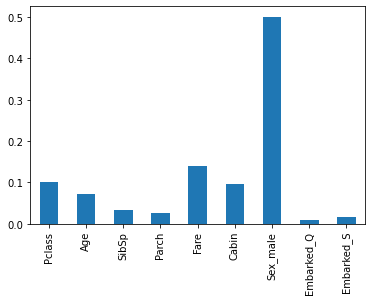

In [62]:
forest_importances = pd.Series(gs.best_estimator_.feature_importances_, index = X_train.columns).plot.bar()

In [ ]:
# for tree 

In [39]:
gs.score(X_train, y_train)

0.8528528528528528

In [40]:
gs.score(X_val, y_val)

0.8116591928251121

## Kaggle Submission
---

Now that we've evaluated our model, let's submit our predictions to Kaggle.

In [41]:
pred = gs.predict(test[features])

In [42]:
test['Survived'] = pred

In [43]:
test[['PassengerId', 'Survived']].to_csv('submission.csv')